### Prediction stock returns with linear regression
### 用线性回归预测股票回报

Load Data 加载数据

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_style('darkgrid')
idx = pd.IndexSlice

YEAR = 252

with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

data.index.names = ['symbol', 'date']
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

# Select Investment Universe 选择投资范围
data = data[data.dollar_vol_rank<100]

# Create Model Data  创建模型数据
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)


# data.info(null_counts=True)
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109434 entries, ('AAL', Timestamp('2013-07-26 00:00:00')) to ('YUM', Timestamp('2015-11-03 00:00:00'))
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109434 non-null  float64
 1   dollar_vol             109434 non-null  float64
 2   dollar_vol_1m          109434 non-null  float64
 3   dollar_vol_rank        109434 non-null  float64
 4   rsi                    109434 non-null  float64
 5   bb_high                109434 non-null  float64
 6   bb_low                 109434 non-null  float64
 7   atr                    109434 non-null  float64
 8   macd                   109434 non-null  float64
 9   return_1d              109434 non-null  float64
 10  return_5d              109434 non-null  float64
 11  return_10d             109434 non-null  float64
 12  return_21d             109434 non-null  float64
 13  return_42d    

Custom MultipleTimeSeriesCV 自定义时间序列交叉验证

In [2]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""
    # 这里其实只是将日期序列进行划分为训练集和测试集，后面再用时间结合原始数据得到新数据。

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            # train_end_idx = test_start_idx + + self.lookahead - 1  # Maybe an extra plus sign 可能多加了+
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# Verify that it works 验证它是否有效
train_period_length = 63     # 3 months
test_period_length = 10      # 10 days
n_splits = int(3 * YEAR/test_period_length)  # 3 years
lookahead = 1                # 向前看1天

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    # df = train.reset_index().append(test.reset_index()) # bad
    df = pd.concat([train.reset_index(), test.reset_index()])  # pandas ≥ 2.0 good
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],  # 一个train的fold有多少天数据
          train_dates.min().date(), train_dates.max().date(),            # 起止时间
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break


63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


Visualization helper functions 可视化辅助函数

In [3]:
# Prediction vs Actual Scatter Plot 预测与实际散点图
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')


# Daily IC Distribution 每日IC(Information Coefficient 信息系数)分布
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()


# Rolling Daily IC 滚动每日IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()



Linear Regression with sklearn 线性回归模型

Information Coefficient (overall): 1.346% (p-value: 0.0255%)


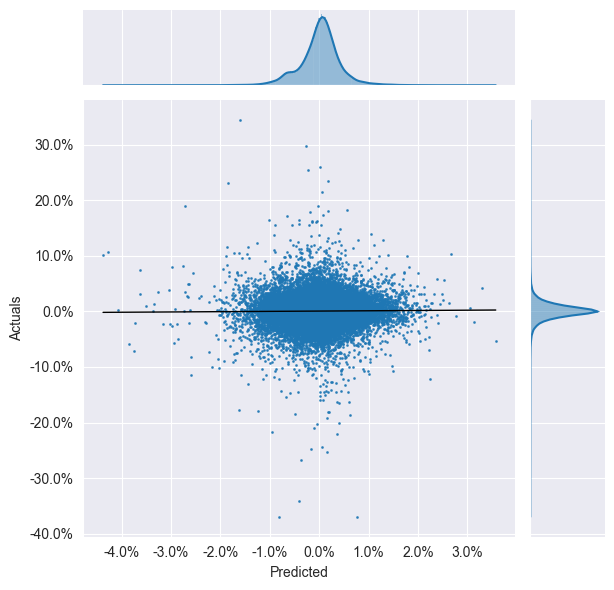

In [4]:
# %%time
# Set up cross-validation 交叉验证
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

# Run cross-validation with LinearRegression 运行线性回归模型的交叉验证

target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

# Persist results 保存
lr_scores.to_hdf('data.h5', 'lr/scores')
lr_predictions.to_hdf('data.h5', 'lr/predictions')
lr_scores = pd.read_hdf('data.h5', 'lr/scores')
lr_predictions = pd.read_hdf('data.h5', 'lr/predictions')

# Evaluate results 评估结果
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

# Prediction vs Actuals Scatter 预测值与实际值散点图
plot_preds_scatter(lr_predictions)

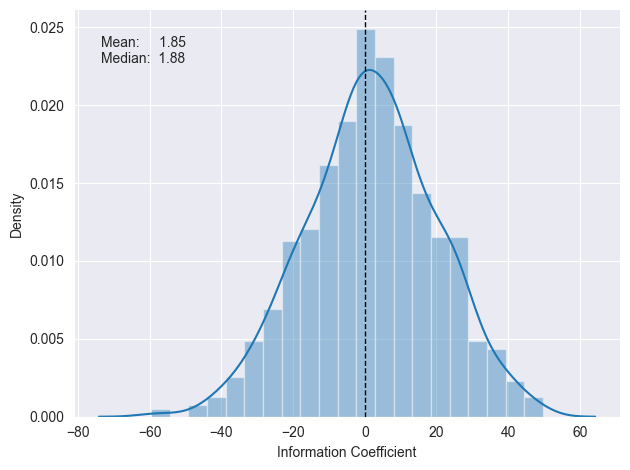

In [5]:
# Daily IC Distribution
plot_ic_distribution(lr_scores)

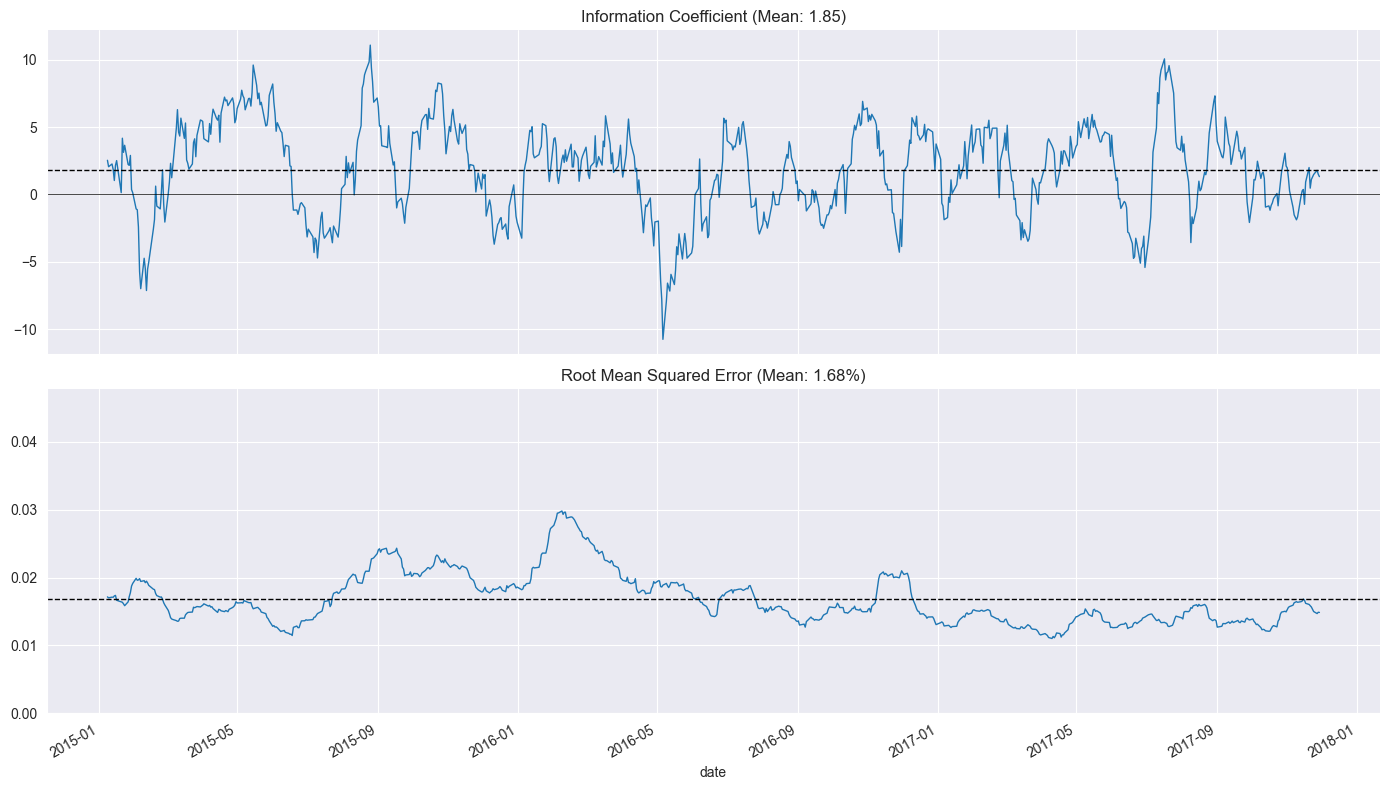

In [6]:
# Rolling Daily IC
plot_rolling_ic(lr_scores)

### Ridge Regression 岭回归

In [7]:
# %%time
# 在用时间序列交叉验证方式，遍历18个 Ridge 正则化强度 alpha，评估每个 alpha 下模型的预测能力（IC 和 RMSE），并记录模型系数，为后续选择最优 alpha 提供依据。
# Define cross-validation parameters
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


# Run cross-validation
target = f'target_{lookahead}d'

X = X.drop([c for c in X.columns if 'year' in c], axis=1)

ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 



Evaluate Ridge Results

In [8]:
# Persist results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf('data.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf('data.h5', 'ridge/predictions')

ridge_scores = pd.read_hdf('data.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf('data.h5', 'ridge/predictions')

# Evaluate Ridge Results
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

ridge_scores.groupby('alpha').ic.describe()


Information Coefficient (overall): 1.394% (p-value: 0.0000%)


,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.851799,18.219597,-59.551020,-10.034014,1.883136,14.295660,49.695733
0.0005,750.0,1.851703,18.219673,-59.551020,-10.034014,1.883136,14.295660,49.695733
0.0010,750.0,1.851703,18.219673,-59.551020,-10.034014,1.883136,14.295660,49.695733
0.0050,750.0,1.851815,18.219743,-59.551020,-10.034014,1.883136,14.295660,49.695733
0.0100,750.0,1.851716,18.219733,-59.551020,-10.034014,1.883136,14.295660,49.695733
0.0500,750.0,1.851883,18.219769,-59.551020,-10.034014,1.883136,14.295660,49.719233
0.1000,750.0,1.852259,18.220119,-59.551020,-10.034014,1.883136,14.295660,49.719233
0.5000,750.0,1.850398,18.220512,-59.610390,-10.018833,1.906636,14.295660,49.719233
1.0000,750.0,1.851394,18.222289,-59.610390,-10.060603,1.899623,14.295660,49.719233


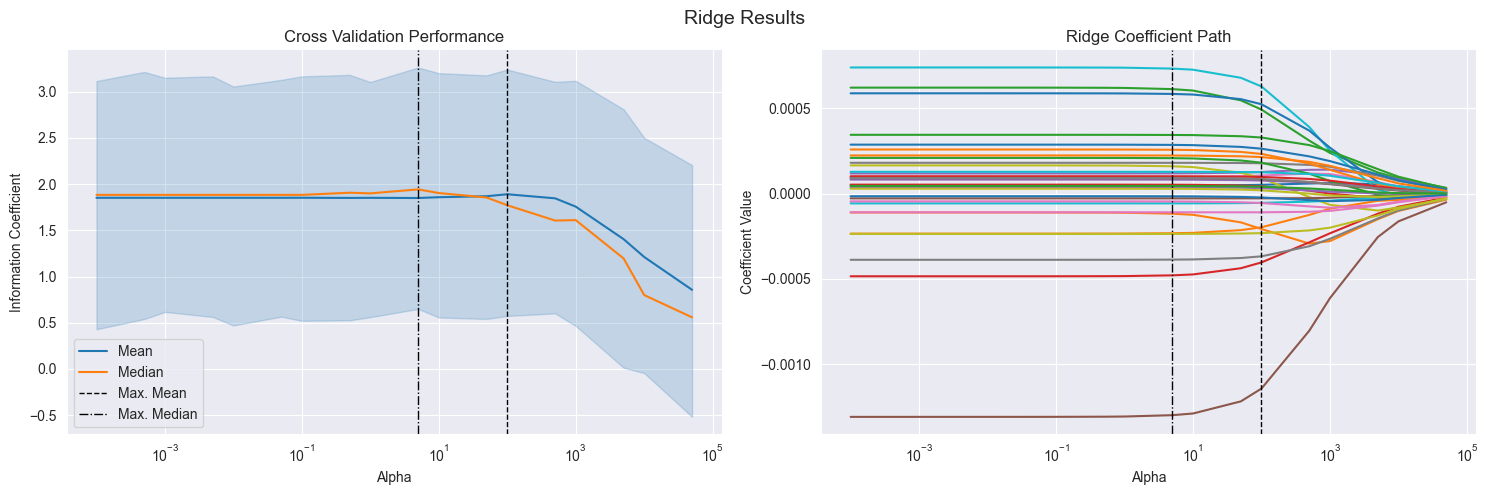

In [9]:

fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

# 下面的左图：展示了不同 alpha 值下模型的 IC 分布。表示当alpha很大时效果变差了。
# 右图：展示了不同 alpha 值下模型的系数路径。表示当alpha很大时，模型的系数突然都变小了。


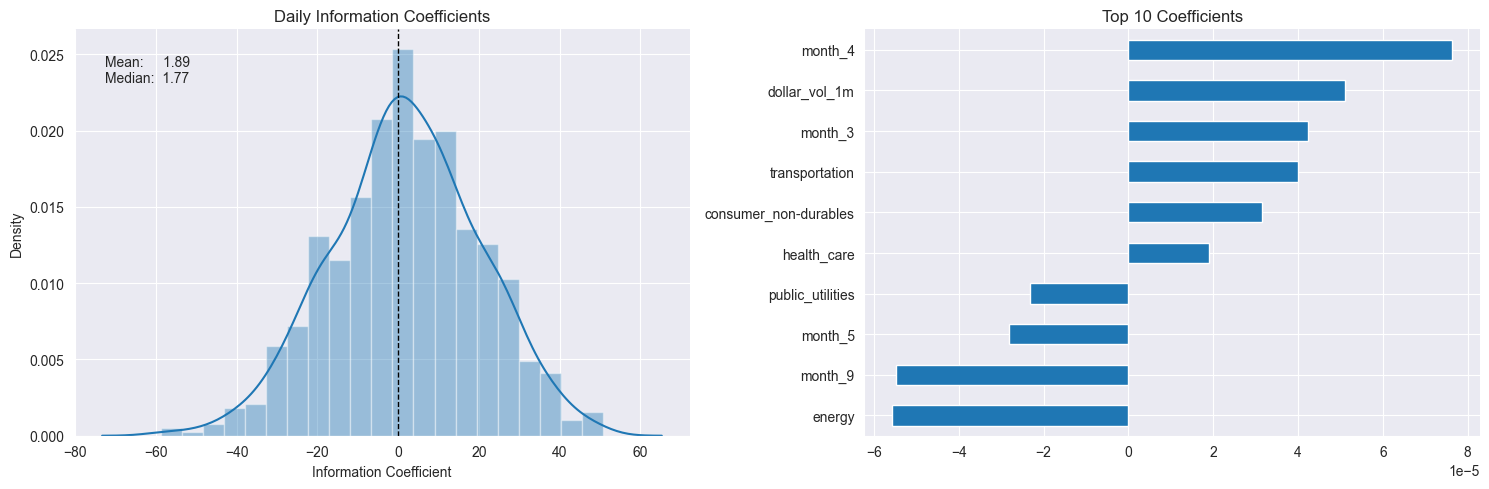

In [10]:
# 只用最优 alpha 下的所有交叉验证折的结果
# 左图：如果分布集中在正值区域，说明模型大多数时候预测方向是对的。如果分布很宽、偏负，说明模型不稳定或信号弱。
# 右图：选出绝对值最大的10个特征，看哪些特征对预测贡献最大。

best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

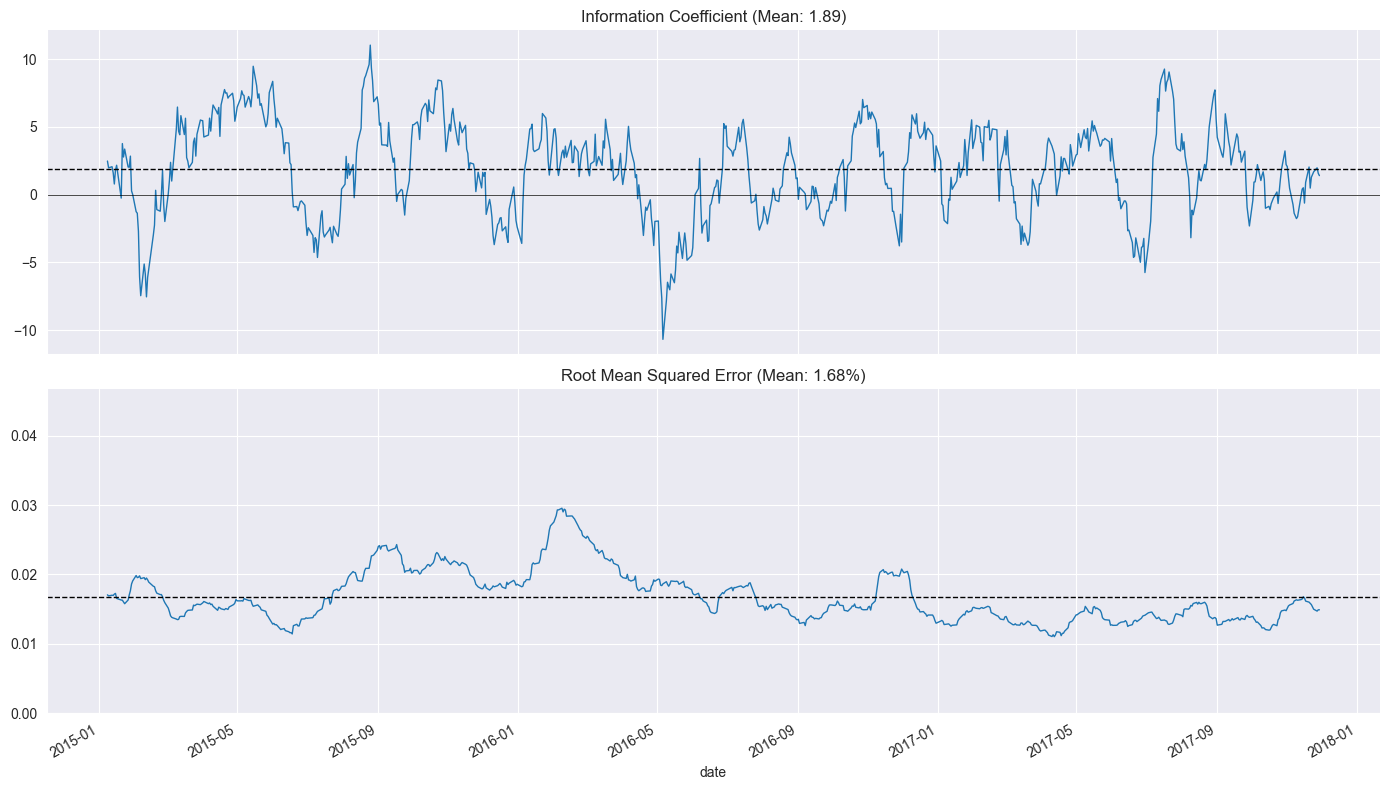

In [11]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

### Lasso CV 套索回归

In [12]:
# 类似地
# Define cross-validation parameters
lasso_alphas = np.logspace(-10, -3, 8)

train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


# Run cross-validation with Lasso regression
target = f'target_{lookahead}d'

scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

# Persist results
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf('data.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf('data.h5', 'lasso/predictions')

1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 

Evaluate Lasso Results 评估

In [13]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

Information Coefficient (overall): 3.371% (p-value: 0.0000%)


,mean,median
alpha,,
1.000000e-10,1.851703,1.883136
1.000000e-09,1.851894,1.883136
1.000000e-08,1.851316,1.883136
1.000000e-07,1.848812,1.896435
1.000000e-06,1.851330,1.884398
1.000000e-05,1.843374,1.784798
1.000000e-04,1.569269,1.635465
1.000000e-03,0.521715,2.001237


False


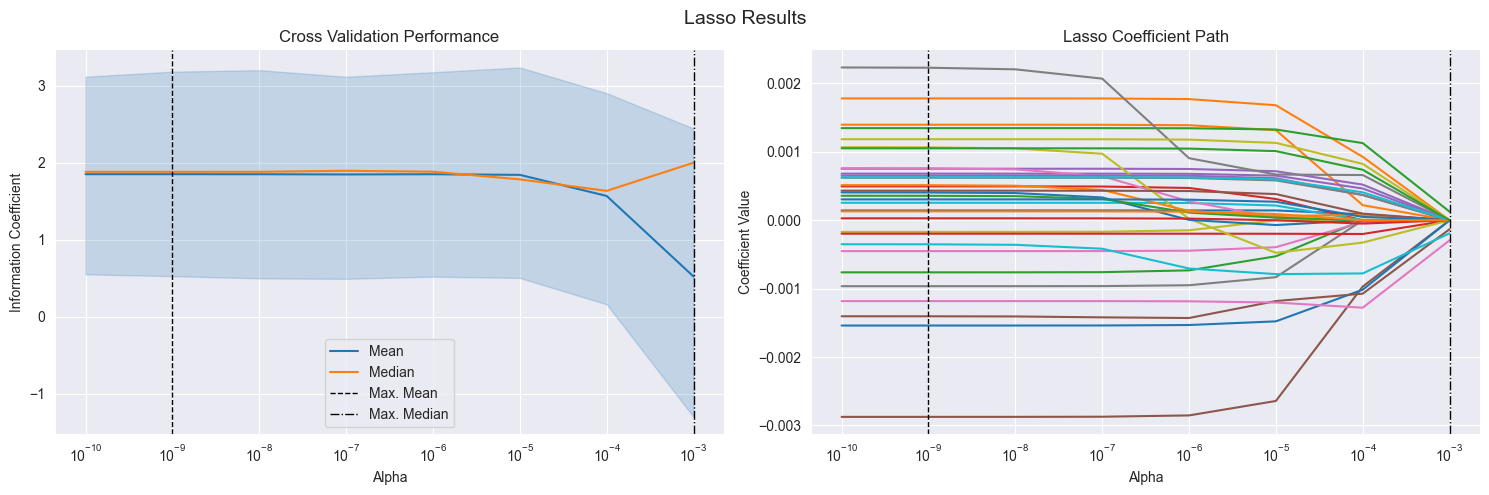

In [14]:
# Lasso Coefficient Path
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

# add code:
# Check if index is unique
print(lasso_scores.index.is_unique) # False表示索引不是唯一的
lasso_scores = lasso_scores.reset_index(drop=True)

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

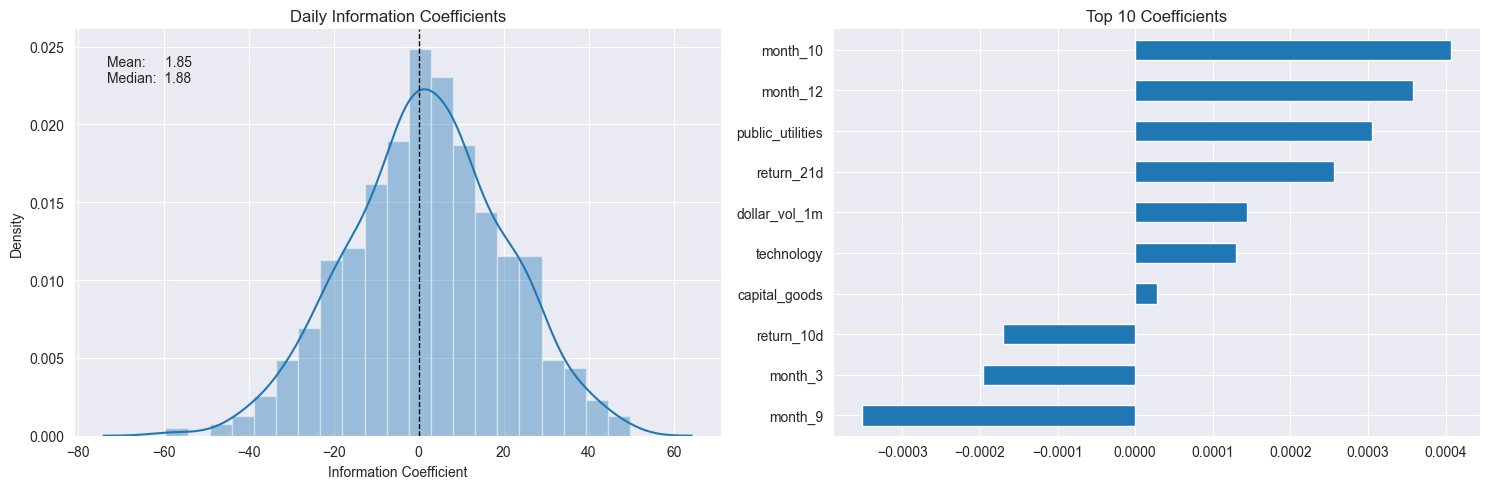

In [15]:
# Lasso IC Distribution and Top 10 Features
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

Compare results 对比模型

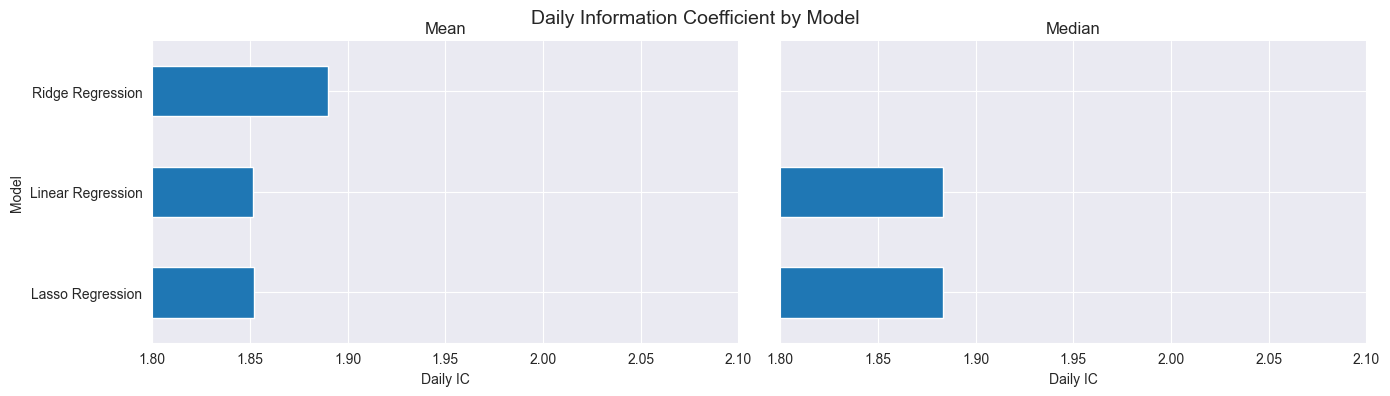

In [16]:
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(1.85, 2), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 2.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)
